## Logistics

We are going to use parallel-tempering, implemented via the python emcee package, to explore our posterior, which consists of the set of distances and gas to dust conversion coefficients to the twelve velocity slices. Since we need to explore a 24 dimensional parameter space, we are going to use 100 walkers, 500 steps each, at 5 different temperatures. If you would like to edit this parameters, simply edit "nwalkers", "ntemps", and "nsteps" in the cell below. However, we are only going to keep the lowest temperature chain ($\beta=1$) for analysis. Since the sampler.chain object from PTSampler returns an array of shape (Ntemps, Nwalkers, Nsteps, Ndim), returning the samples for all walkers, steps, and dimensions at $\beta=1$ would correspond to sampler.chain[0,:,:,:]. To decrease your value of $\beta$ simply increase the index for the first dimension. For more information on how PTSampler works, see http://dan.iel.fm/emcee/current/user/pt/. We will set off our walkers in a ball around the kinematic distance estimates for the Cepheus molecular cloud given by a flat rotation curve from Leroy & Rosolowsky 2006. You can edit the starting positions of the walkers by editing the "result" variable below. We are going to discard the first 100 steps of every walker's chain as burn-in

### Setting up the positional arguments for PTSampler

We need to feed PTSampler the required positional arguments for the log_likelihood and log_prior function. We do this using the fetch_args function from the io module, which creates an instance of the pixclass object that holds our data and metadata. Fetch_args accepts three arguments: 

- A string specifiying the h5 filename containing your data, in our case 89996.h5
- The prior bounds you want to impose on a) distances (flat prior), in units of distance modulus and b) gas to dust coefficients (also flat prior). In the script, we multiply our input literature value of choice by this prefactor. The bounds are given as a list in the format [lower_distance, upper_distance, lower_coefficient, upper_coefficient]. For distance, this must be between 4 and 19, because that's the distance modulus range of our stellar posterior array. 
- The gas-to-dust coefficient you'd like to use, given as a float; for this tutorial, we are pulling a value from the literature of 0.06 magnitudes/K. This value is then multiplied by the set of c coefficients we're determining as part of the parameter estimation problem. 

Fetch_args will then return the correct arguments for the log_likelihood and log_prior functions within the model module. 

Here we go!

In [1]:
import emcee
from dustcurve import model
import seaborn as sns
import numpy as np
from dustcurve import pixclass
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from dustcurve import io
from dustcurve import hputils
from dustcurve import kdist
%matplotlib inline

#this code pulls snippets from the PHYS201 week 9 MCMC notebook written by Vinny Manohoran and the PHYS201 L9 solutions,
#written by Tom Dimiduk and Kevin Shain

#suppress obnoxious deprecation warning that doesn't affect output
warnings.filterwarnings("ignore", category=Warning, module="emcee")

fnames='89996.h5'

#fetch the required likelihood and prior arguments for PTSampler
ldata,pdata=io.fetch_args(fnames,[4,19,0,10],0.06)

# the model has 12 parameters; we'll use 50 walkers, 500 steps each, at 5 different temps
ndim=24
nslices=12
nwalkers = 50
nsteps = 500
ntemps=5

#setting off the walkers at the kinematic distance given by the literature, assuming a flat rotation curve, theta=220 km/s, R=8.5 kpc
#Details on rotation curve given in Rosolowsky and Leroy 2006
vslices=np.linspace(-15.6,-1.3,12)
klong=np.ones(12)*109.5
klat=np.ones(12)*13.5
kdist=kdist.kdist(klong,klat,vslices)
kdistmod=5*np.log10(kdist)-5

#slightly perturb the starting positions for each walker, in a ball centered around result
result=kdistmod.tolist()
result.extend(0.06 for i in range (nslices))
starting_positions = [[result + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] for j in range(ntemps)]

#set up the starting position array and add variance (up to 1 in distance modulus) to each walker 
starting_positions = [[result + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] for j in range(ntemps)]


#set up the sampler object
sampler = emcee.PTSampler(ntemps, nwalkers, ndim, model.log_likelihood, model.log_prior, loglargs=(ldata), logpargs=[pdata])

#burn in, and save final positions for all parameters, which we'll then set off our walkers at for the "real" thing
post_burn_pos, prob, state = sampler.run_mcmc(starting_positions, 200)
sampler.reset()

print("Setup complete")

/n/home12/czucker/envs/PYTHON3/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Total number of stars used in analysis: 3065
Setup complete


In [2]:
# run the sampler and time how long it takes
%time sampler.run_mcmc(post_burn_pos, nsteps)
print('Sampler Done')

CPU times: user 4min 21s, sys: 22 ms, total: 4min 21s
Wall time: 4min 21s
Sampler Done


The sampler is done running, so now let's check out the results. We are going to print out our mean acceptance fraction across all walkers for the coldest temperature chain. 

We are going to discard the first 300 steps of each chain as burn-off; to change the number of steps to burn off, simply edit the 3rd dimension of sampler.chain[0,:,n:,:] and input your desired value of n. Next we are going to plot what the chains look like, for each distance parameter and for the first ten walkers. The chains should all be reasonably well-mixed. Finally, we are going to compute and print out the 50th, 16th, and 84th percentile of chain for each distance parameter, using the "quantile" attribute of a pandas dataframe object (in our case "parameter_samples"). The 50th percentile measurement represents are best guess for the each distance parameter, while the differences between the 16th and 50th gives us a lower limit and the difference between the 50th and 84th percentile gives us an upper limit.

Our mean acceptance fraction for the coldest chain is 0.07
d1: 12.335 + 1.445 - 0.899
d2: 11.813 + 1.226 - 0.540
d3: 9.597 + 0.236 - 1.787
d4: 9.775 + 0.095 - 0.176
d5: 10.124 + 2.227 - 0.553
d6: 7.473 + 2.123 - 1.137
d7: 5.631 + 4.427 - 0.617
d8: 10.299 + 1.399 - 3.394
d9: 7.294 + 0.669 - 1.133
d10: 5.381 + 2.140 - 0.552
d11: 6.646 + 0.567 - 1.673
d12: 6.050 + 0.781 - 0.371
c13: 0.221 + 0.264 - 0.176
c14: 1.414 + 2.152 - 0.620
c15: 2.285 + 0.133 - 0.571
c16: 3.000 + 0.364 - 0.466
c17: 1.423 + 0.597 - 0.556
c18: 0.193 + 0.163 - 0.156
c19: 0.170 + 1.262 - 0.126
c20: 0.215 + 0.316 - 0.164
c21: 2.451 + 0.271 - 1.040
c22: 1.447 + 0.574 - 0.318
c23: 3.824 + 1.744 - 1.442
c24: 1.106 + 0.887 - 0.775


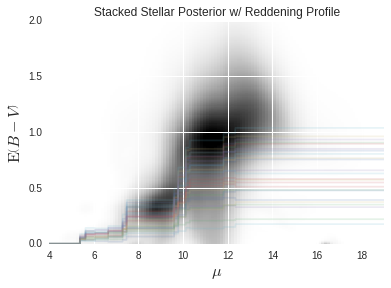

In [ ]:
#Extract the coldest [beta=1] temperature chain from the sampler object; discard first 100 samples as burnin
samples_cold = sampler.chain[0,:,100:,:]
traces_cold = samples_cold.reshape(-1, ndim).T

#check out acceptance fraction:
print("Our mean acceptance fraction for the coldest chain is %.2f" % np.mean(sampler.acceptance_fraction[0]))

#find best fit values for each of the 24 parameters (12 d's and 12 c's)
theta=pd.DataFrame(traces_cold)
quantile_50=theta.quantile(.50, axis=1).values
quantile_84=theta.quantile(.84, axis=1).values
quantile_16=theta.quantile(.16, axis=1).values

upperlim=quantile_84-quantile_50
lowerlim=quantile_50-quantile_16

#print out distances
for i in range(0,int(len(quantile_50)/2)):
    print('d%i: %.3f + %.3f - %.3f' % (i+1,quantile_50[i],upperlim[i], lowerlim[i]))

#print out coefficients
for i in range(int(len(quantile_50)/2), int(len(quantile_50))):
    print('c%i: %.3f + %.3f - %.3f' % (i+1,quantile_50[i],upperlim[i], lowerlim[i]))
    
from dustcurve import pixclass

unique_co,indices,unique_post,ratio=ldata
pixObj=pixclass.PixStars('/n/fink1/czucker/Data/89996.h5')
post_array=pixObj.get_p()


from dustcurve import plot_posterior
#plot the reddening profile over the stacked, normalized stellar posterior surfaces    
plot_posterior.plot_posterior(np.asarray(post_array),np.linspace(4,19,120),np.linspace(0,7,700),quantile_50,ratio,unique_co,[4,19],[0,2])


Let's see what our chains look like...

In [ ]:
#set up subplots for chain plotting
axes=['ax'+str(i) for i in range(ndim)]
fig, (axes) = plt.subplots(ndim, figsize=(5,30))

plt.tight_layout()

for i in range(0,ndim):
    if i<int(ndim/2):
        axes[i].set(ylabel='d%i' % i)
    else:
        axes[i].set(ylabel='c%i' % i)

#plot chains for each parameter
    for i in range(0,ndim):
        sns.tsplot(traces_cold[i],ax=axes[i])


In [ ]:
import h5py
#Save the results of the sampler:
output=fnames

fwrite = h5py.File("/n/fink1/czucker/Output/"+str(output), "w")
chaindata = fwrite.create_dataset("/chains", sampler.chain.shape, dtype='f')
chaindata[:,:,:,:]=sampler.chain
    
probdata = fwrite.create_dataset("/probs", sampler.lnprobability.shape, dtype='f')
probdata[:,:,:]=sampler.lnprobability


fwrite.close()